<a href="https://colab.research.google.com/github/sebasatarama/TA3/blob/main/SolvingTA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ortools 1> /dev/null

In [4]:
from ortools.sat.python import cp_model
from random import randint as rndi
import matplotlib.pyplot as plt
import pandas as pd

#Getting Data

In [55]:
url_data = 'https://raw.githubusercontent.com/sebasatarama/TA3/main/covid19_LimaMetropolitana.csv'

In [14]:
data = pd.read_csv(url_data)

In [15]:
data.head()

,Tipo de Prueba,Latitud,Longitud,Edad
0,Antigeno,-11.704438,-76.137277,63
1,Anticuerpo,-11.128193,-77.773252,89
2,Antigeno,-10.847917,-77.503397,95
3,Antigeno,-10.628100,-77.286523,78
4,PCR,-12.338830,-75.965435,32


#Preproccesing

In [ ]:
def normalize(x, min_value, max_value):
  normalized = ((x - min_value) / (max_value - min_value)) * 100
  return normalized

## Patients

In [19]:
#getting normalized values
lat = list(data['Latitud'])
lon = list(data['Longitud'])
minlat = min(lat)
maxlat = max(lat)
minlon = min(lon)
maxlon = max(lon)
nlat = [normalize(x, minlat, maxlat) for x in lat]
nlon = [normalize(x, minlon, maxlon) for x in  lon]

In [21]:
#rounding values
rlat = [round(x) for x in nlat]
rlon = [round(x) for x in nlon]

In [23]:
#getting the locations
patient_locs = [(x, y) for x, y in zip(rlat, rlon)]

In [25]:
#deleting every repeated value
patient_locs = list(set(patient_locs))
n_patients = len(patient_locs)
print(n_patients)

941


## Hospitals and beds

In [ ]:
#hospital information (6 hospitals across Lima)
#Cayetano Heredia -12.02087, -77.05742
#Surco Salud -12.165445, -76.99042
#Emmsa -12.038580, -76.946547
#Essalud Callao -12.045392, -77.109225
#San Juan de Lurigancho -11.966190, -77.003513
#Juan Pablo -12.218932, -76.947119

In [45]:
hlat = [-12.02087, -12.165445, -12.038580, -12.045392, -11.966190, -12.218932]
hlon = [-77.05742, -76.99042, -76.946547, -77.109225, -77.003513, -76.947119]
#we will use de max and min of hospital location se they will be at long distance different locations
nhlat = [normalize(x, min(hlat), max(hlat)) for x in hlat]
nhlon = [normalize(x, min(hlon), max(hlon)) for x in hlon]
hospital_locs = [(round(x), round(y)) for x, y in zip(nhlat, nhlon)]

In [28]:
#beds quantity per hospital will be random
n_hospitals = 6
n_beds_per_hospitals = [rndi(40, 80) for _ in range(n_hospitals)]

## Patient Severity

In [33]:
#Since we only have information about age, wi will assume the severity depending of the age range
edad = list(data['Edad'])
def severity(edad):
    if edad<20:
      return 1
    elif edad < 40:
      return 2
    elif edad < 60:
      return 3
    elif edad <80:
      return 4
    else: return 5
patient_severities = [severity(x) for x in edad]
patient_severities = patient_severities[:n_patients]

In [41]:
plt.rcParams['figure.figsize'] = (40, 15)

In [39]:
print(n_beds_per_hospitals)
n_beds_total = sum(n_beds_per_hospitals)
print(n_beds_total)
print(patient_locs)
print(hospital_locs)
print(patient_severities)

[77, 44, 67, 69, 59, 53]
369
[(38, 23), (79, 24), (59, 55), (58, 1), (55, 66), (70, 55), (89, 68), (67, 68), (17, 58), (19, 0), (90, 51), (63, 34), (30, 9), (91, 25), (11, 5), (77, 90), (40, 41), (48, 54), (40, 50), (91, 34), (75, 8), (60, 28), (17, 94), (21, 46), (40, 68), (75, 35), (62, 74), (64, 16), (10, 45), (85, 48), (81, 96), (72, 29), (56, 12), (39, 90), (62, 92), (10, 54), (74, 57), (14, 15), (45, 30), (51, 64), (93, 79), (37, 26), (3, 24), (57, 4), (14, 33), (46, 13), (32, 78), (15, 7), (97, 58), (14, 51), (7, 12), (55, 61), (13, 92), (70, 59), (7, 21), (55, 70), (17, 53), (28, 53), (77, 76), (9, 58), (5, 69), (83, 7), (82, 51), (77, 94), (9, 76), (33, 6), (69, 99), (27, 93), (44, 24), (84, 8), (30, 98), (64, 11), (10, 40), (39, 85), (74, 52), (86, 17), (93, 74), (14, 19), (84, 93), (97, 35), (98, 0), (43, 64), (31, 99), (89, 31), (86, 44), (59, 27), (3, 37), (67, 40), (1, 67), (97, 53), (90, 14), (35, 78), (47, 43), (26, 20), (59, 54), (100, 55), (55, 65), (36, 52), (100, 64

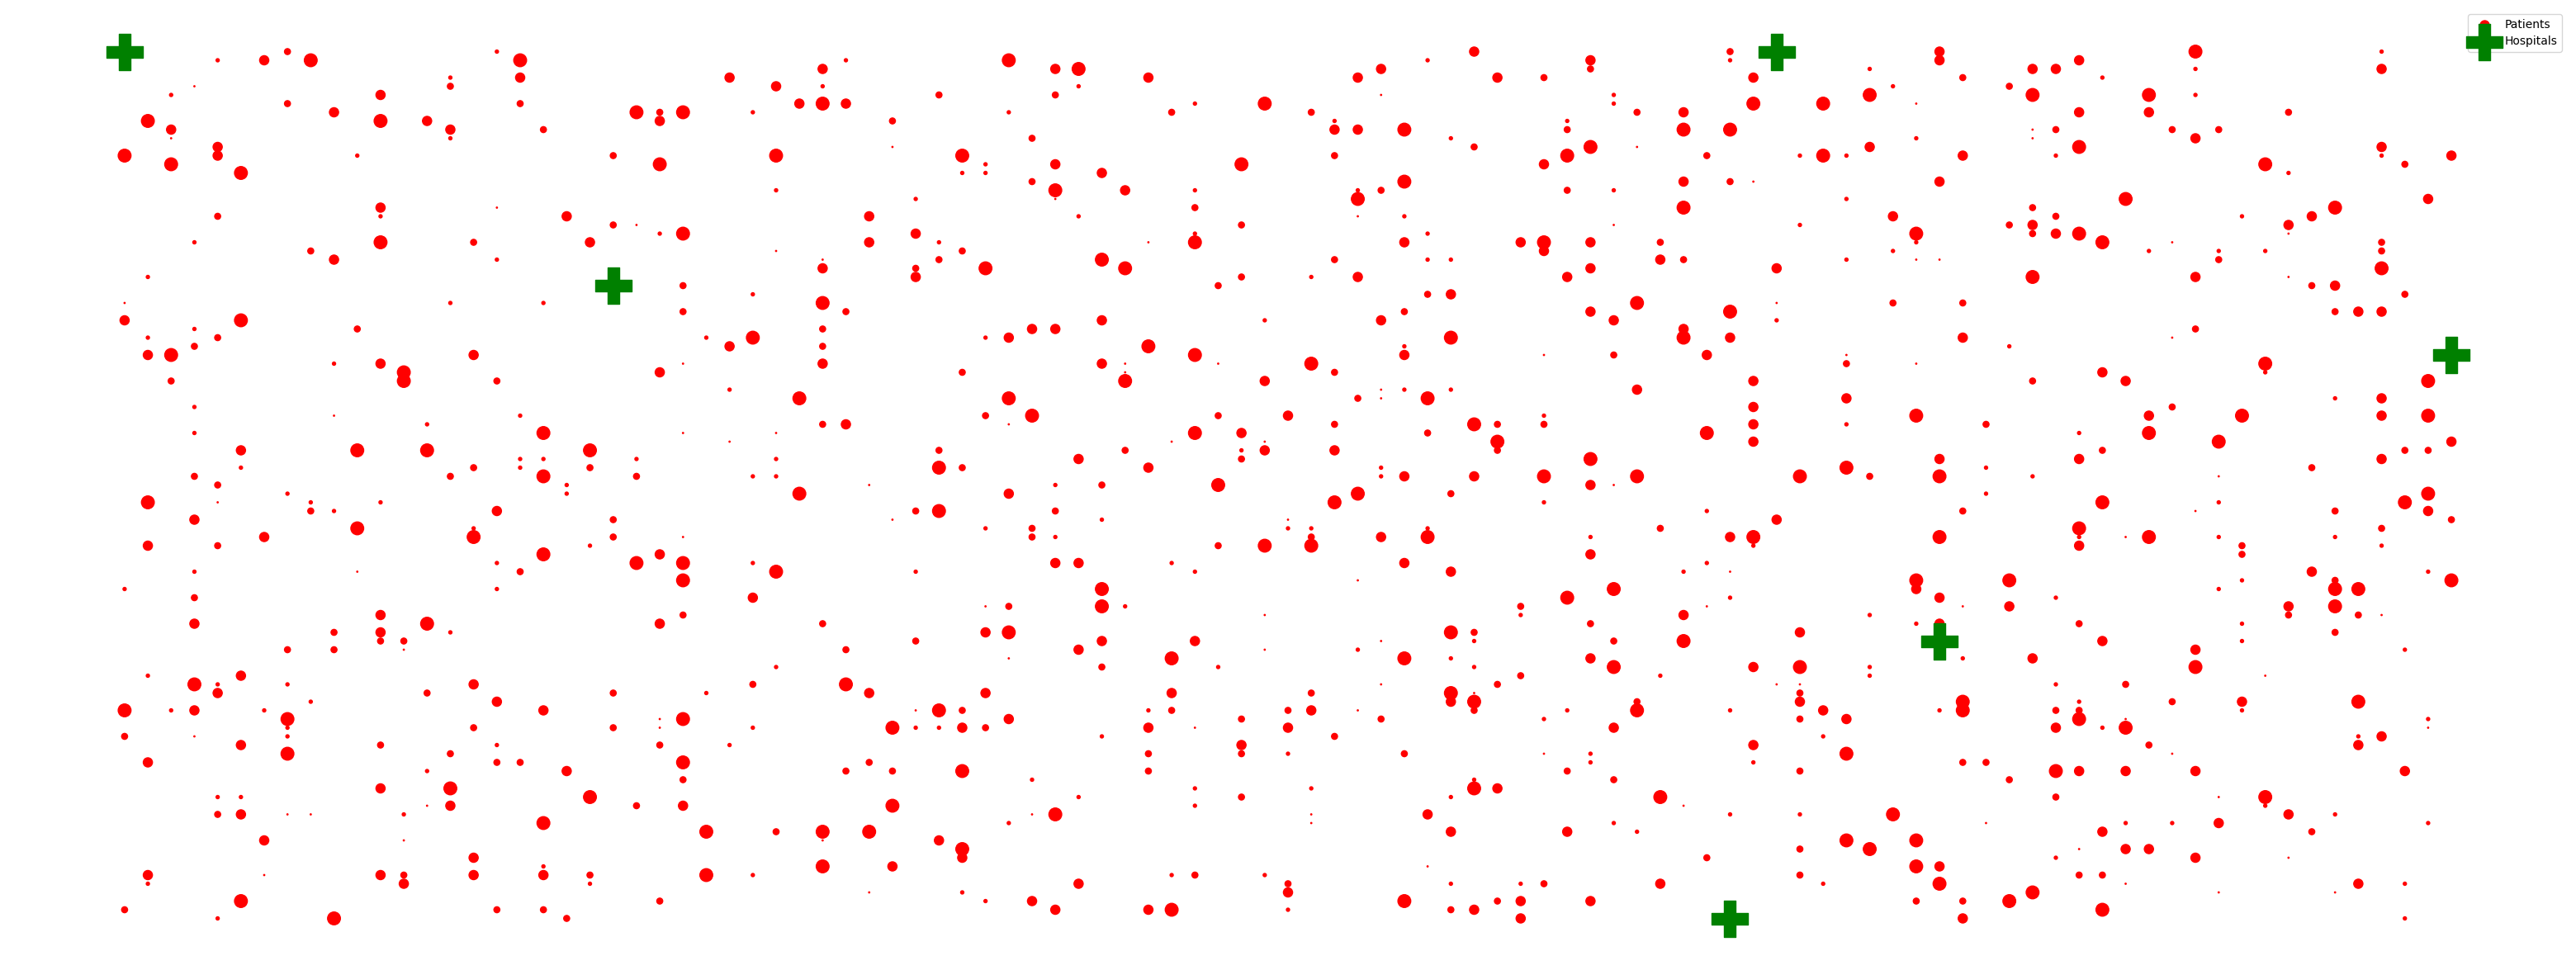

In [46]:
severity_size = [sev**3 for sev in patient_severities]
plt.scatter(*zip(*patient_locs), s=severity_size, c='r', label="Patients")
plt.scatter(*zip(*hospital_locs), s=1000, c='g', marker="P", label="Hospitals")
plt.legend()
plt.axis("off")
plt.show()

#Variables

In [47]:
model = cp_model.CpModel()

x = {}
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        for k in range(n_patients):
            x[(i, j, k)] = model.NewBoolVar(f"x_{i}_{j}_{k}")

#Constraints

$$
\forall i \in H, \forall j \in B_i,\sum_{k \in P}{x_{ijk}} \le 1
$$

In [48]:
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        model.Add(sum([x[(i, j, k)] for k in range(n_patients)]) <= 1)

$$
\forall k \in P, \sum_{i\in H}\sum_{j\in B_i}x_{ijk} \le 1
$$

In [49]:
for k in range(n_patients):
    n_pat_per_bed_hosp = []
    for i in range(n_hospitals):
        n_pat_per_bed_hosp.append(sum(x[(i,j,k)] for j in
                                      range(n_beds_per_hospitals[i])))
        model.Add(sum(n_pat_per_bed_hosp) <= 1)

$$
\max_{sol}{\sum_{i \in H}{\sum_{j \in B_i}{\sum_{k \in P}{x_{ijk}}}}}
$$

In [50]:
def dist(p1, p2):
    return int(((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5)

max_dist = 0
for i in range(n_hospitals):
    for k in range(n_patients):
        d = dist(hospital_locs[i], patient_locs[k])
        if max_dist < d:
            max_dist = d

In [51]:
pref = []
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        for k in range(n_patients):
            pref += [x[(i,j,k)]*(100 - 100*dist(patient_locs[k], hospital_locs[i]) / max_dist + 100 * patient_severities[k] / 5)]
model.Maximize(sum(pref))

# IT'S SOLVING TIME!

In [52]:
solver = cp_model.CpSolver()
status = solver.Solve(model)
if status == cp_model.OPTIMAL:
    print("Time:", solver.WallTime())
    for i in range(n_hospitals):
        print(f"Hospital {i+1} {hospital_locs[i]}, has {n_beds_per_hospitals[i]} beds")
        for j in range(n_beds_per_hospitals[i]):
            for k in range(n_patients):
                if solver.Value(x[(i,j,k)]):
                    print(f"\tPatient {k+1} in bed {j+1}")
    print()

Time: 1069.260819012
Hospital 1 (78, 32), has 77 beds
	Patient 887 in bed 1
	Patient 576 in bed 2
	Patient 666 in bed 3
	Patient 32 in bed 4
	Patient 782 in bed 5
	Patient 430 in bed 6
	Patient 532 in bed 7
	Patient 129 in bed 8
	Patient 373 in bed 9
	Patient 750 in bed 10
	Patient 302 in bed 11
	Patient 166 in bed 12
	Patient 917 in bed 13
	Patient 635 in bed 14
	Patient 376 in bed 15
	Patient 489 in bed 16
	Patient 857 in bed 17
	Patient 300 in bed 18
	Patient 289 in bed 19
	Patient 724 in bed 20
	Patient 634 in bed 21
	Patient 785 in bed 22
	Patient 377 in bed 23
	Patient 854 in bed 24
	Patient 390 in bed 25
	Patient 830 in bed 26
	Patient 297 in bed 27
	Patient 184 in bed 28
	Patient 200 in bed 29
	Patient 232 in bed 30
	Patient 934 in bed 31
	Patient 145 in bed 32
	Patient 820 in bed 33
	Patient 601 in bed 34
	Patient 878 in bed 35
	Patient 329 in bed 36
	Patient 255 in bed 37
	Patient 172 in bed 38
	Patient 560 in bed 39
	Patient 2 in bed 40
	Patient 615 in bed 41
	Patient 739 in

In [53]:
plot_lines = [[] for _ in range(n_hospitals)]
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        for k in range(n_patients):
            if solver.Value(x[(i,j,k)]):
                abcise_line = [hospital_locs[i][0], patient_locs[k][0]]
                ordered_line = [hospital_locs[i][1], patient_locs[k][1]]
                plot_lines[i].append([abcise_line, ordered_line])

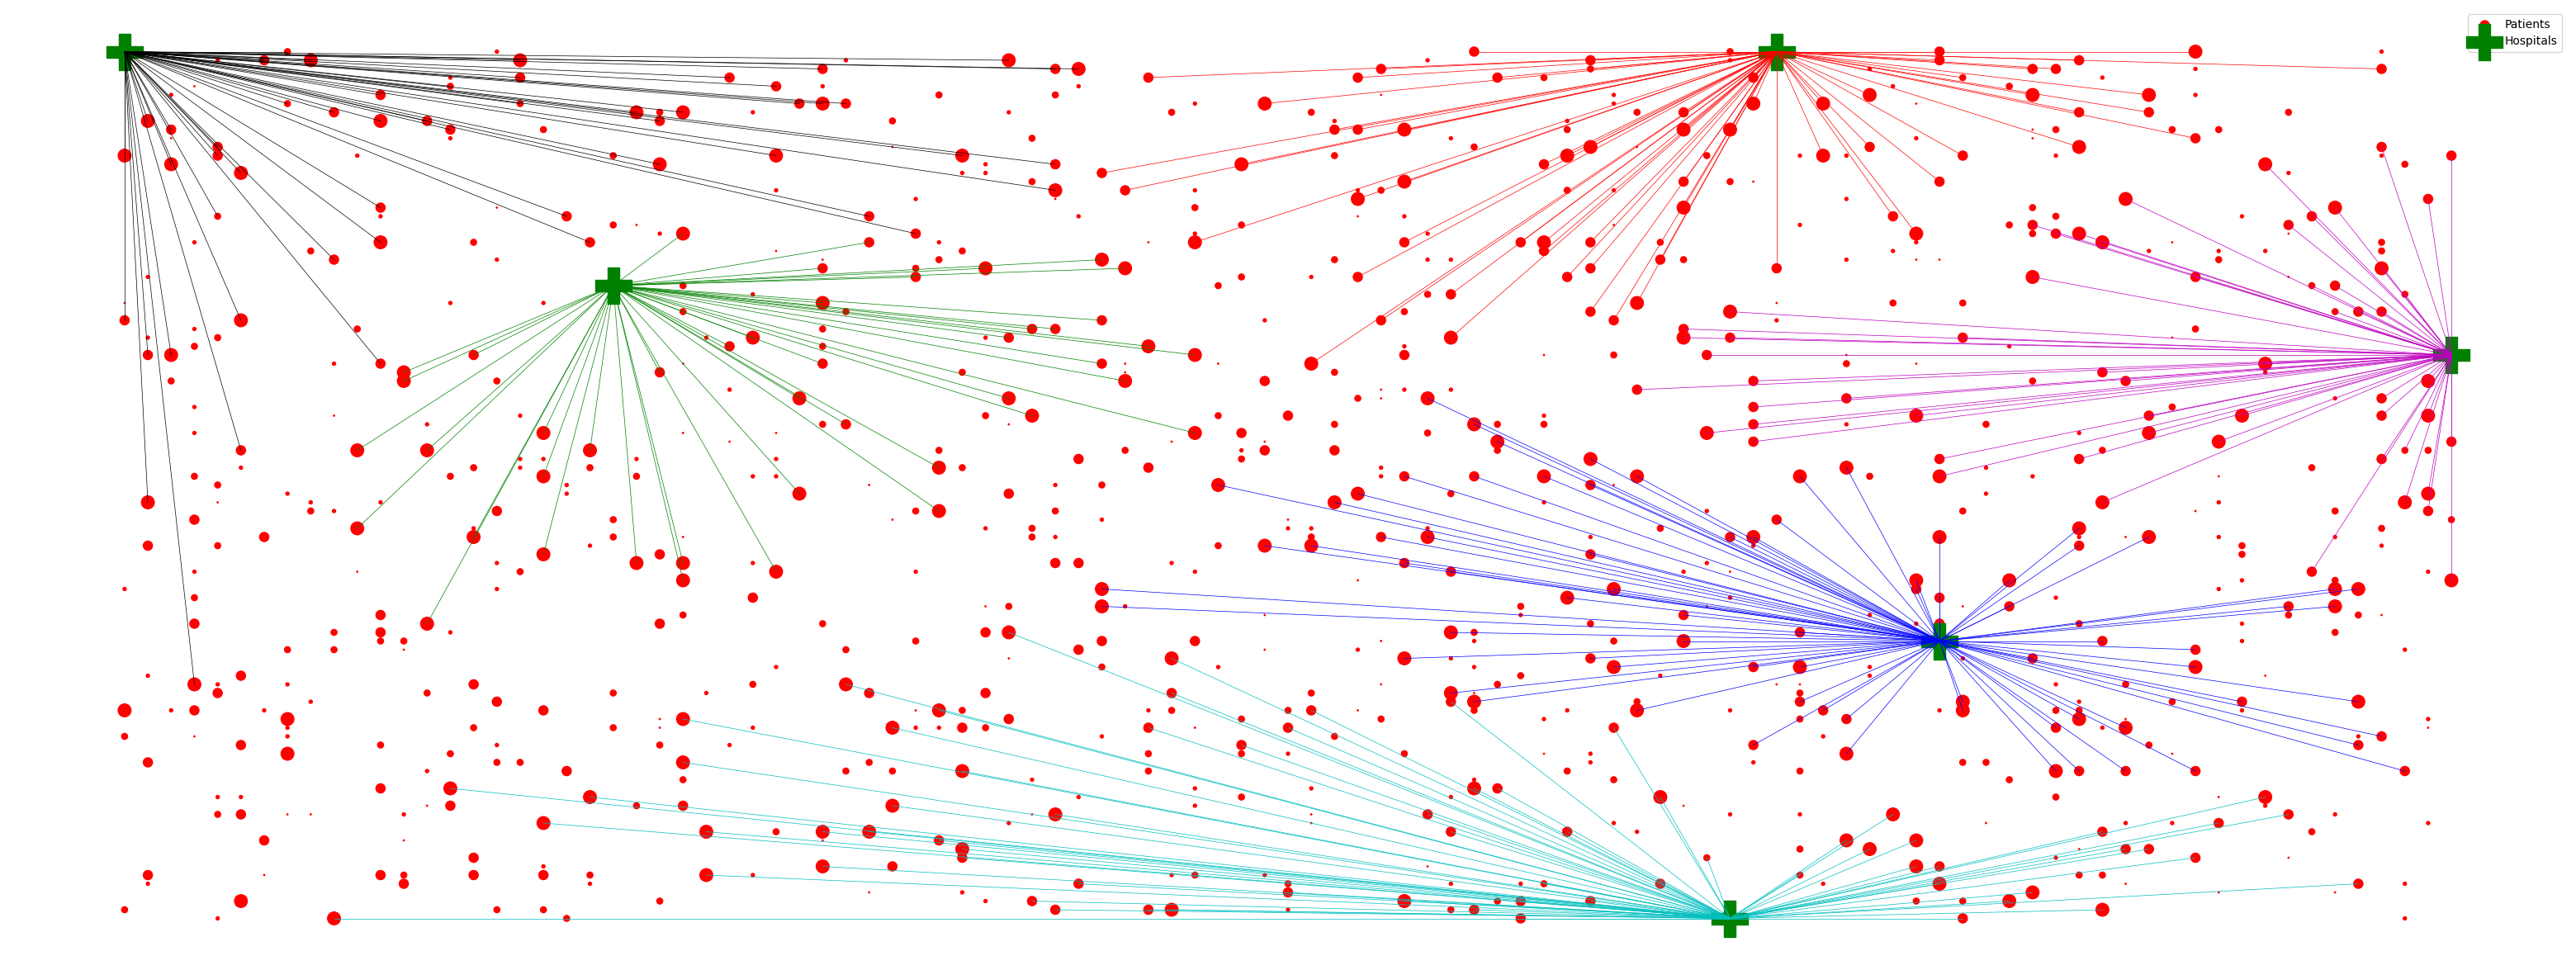

In [54]:
from itertools import cycle

colors = cycle("bgrcmk")
for i in range(n_hospitals):
    c = next(colors)
    for x, y in plot_lines[i]:
        plt.plot(x, y, c=c, linewidth=.5)
plt.scatter(*zip(*patient_locs), s=severity_size, c='r', label="Patients")
plt.scatter(*zip(*hospital_locs), s=1000, c='g', marker="P", label="Hospitals")
plt.legend()
plt.axis("off")
plt.show()